In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
from IPython.core.display import display, HTML
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.models import Model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 6]

In [4]:
with open('../spectrograms.obj', 'rb') as specgram_file:
    specgrams = pickle.load(specgram_file)

print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 78


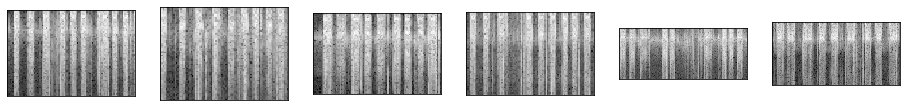

In [5]:
n=6
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(specgrams[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [6]:
rows = specgrams[0].shape[0]
print(rows)

def encode(specgrams, min_columns, max_columns):
    return [specgram[:,:min_columns].reshape(rows*min_columns) for specgram in specgrams if min_columns <= specgram.shape[1] <= max_columns]

def decode(encoded_specgrams):
    columns = encoded_specgrams[i].shape[0]
    return [specgram.reshape(rows, int(columns/rows)) for specgram in encoded_specgrams]

64


In [7]:
reshape = encode(specgrams, 68, 120)
reconstruct = decode(reshape)

X_train, X_test = train_test_split(reshape, test_size=0.25, shuffle=False)
print(X_train[10].shape)
print('Training samples: ' + str(len(X_train)))
print('Test samples: ' + str(len(X_test)))

(4480,)
Training samples: 53
Test samples: 18


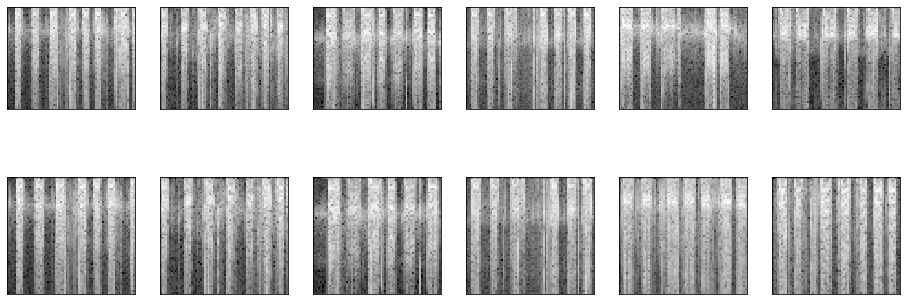

In [8]:
# Testing encode and decode: upper(original) must be equal to lower(encoded and decoded)

n=6
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(specgrams[i][:,:80], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(reconstruct[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Autoencoder Model

In [20]:
input_img = Input(X_train[0].shape)

# encoder
code = Dense(1280, activation='relu')(input_img)
code = Dropout(0.2)(code)
code = Dense(320, activation='relu')(code)
code = Dropout(0.2)(code)
code = Dense(80, activation='relu')(code)
code = Dropout(0.2)(code)

# decoder
x_hat = Dense(320, activation='relu')(code)
x_hat = Dropout(0.2)(x_hat)
x_hat = Dense(1280, activation='relu')(x_hat)
x_hat = Dropout(0.2)(x_hat)
x_hat = Dense(4480, activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary(line_length=55)

_______________________________________________________
Layer (type)            Output Shape          Param #  
input_11 (InputLayer)   (None, 4480)          0        
_______________________________________________________
dense_61 (Dense)        (None, 1280)          5735680  
_______________________________________________________
dropout_51 (Dropout)    (None, 1280)          0        
_______________________________________________________
dense_62 (Dense)        (None, 320)           409920   
_______________________________________________________
dropout_52 (Dropout)    (None, 320)           0        
_______________________________________________________
dense_63 (Dense)        (None, 80)            25680    
_______________________________________________________
dropout_53 (Dropout)    (None, 80)            0        
_______________________________________________________
dense_64 (Dense)        (None, 320)           25920    
________________________________________________

In [10]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')

# tamanho do batch por iteracao
batch_size = 10

# número de épocas 
epochs = 100

# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = autoencoder.fit([X_train], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=([X_test], [X_test]))

Train on 53 samples, validate on 18 samples
Epoch 1/100
53/53 [==============================] - 2s 36ms/step - loss: 0.0435 - val_loss: 0.0426
Epoch 2/100
53/53 [==============================] - 1s 14ms/step - loss: 0.0430 - val_loss: 0.0426
Epoch 3/100
53/53 [==============================] - 1s 14ms/step - loss: 0.0429 - val_loss: 0.0425
Epoch 4/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0428 - val_loss: 0.0425
Epoch 5/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0428 - val_loss: 0.0425
Epoch 6/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0427 - val_loss: 0.0425
Epoch 7/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0427 - val_loss: 0.0424
Epoch 8/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0426 - val_loss: 0.0424
Epoch 9/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0426 - val_loss: 0.0424
Epoch 10/100
53/53 [==============================] - 1s

Epoch 82/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0254 - val_loss: 0.0260
Epoch 83/100
53/53 [==============================] - 1s 14ms/step - loss: 0.0252 - val_loss: 0.0259
Epoch 84/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0253 - val_loss: 0.0260
Epoch 85/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0251 - val_loss: 0.0260
Epoch 86/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0251 - val_loss: 0.0259
Epoch 87/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0251 - val_loss: 0.0260
Epoch 88/100
53/53 [==============================] - 1s 14ms/step - loss: 0.0252 - val_loss: 0.0259
Epoch 89/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0251 - val_loss: 0.0263
Epoch 90/100
53/53 [==============================] - 1s 14ms/step - loss: 0.0250 - val_loss: 0.0260
Epoch 91/100
53/53 [==============================] - 1s 13ms/step - loss: 0.0249 - val_los

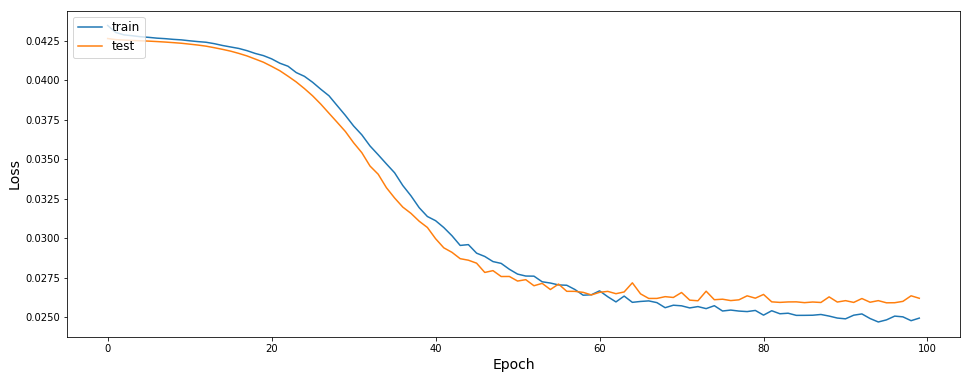

In [11]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['train', 'test'], loc='upper left', fontsize=12)
plt.show()

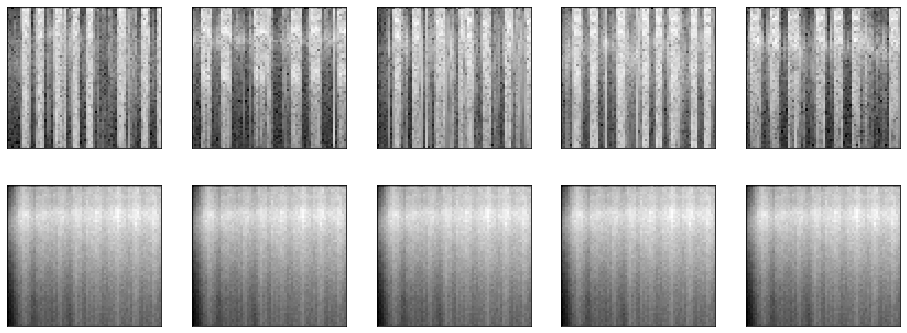

In [12]:
decoded_test = decode(X_test)
decoded_predictions = decode(autoencoder.predict([X_test]))

n=5
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(decoded_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_predictions[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()